In [117]:
# =========================
# SCAPE DoG evaluation rig
# =========================
# Requirements in your env:
#   torch, torchvision, piq, opencv-python, numpy, pandas, matplotlib
# Project imports that you already use:
#   utils.robust_percentile_normalization
#   utils.shift_stimulus_to_phosphene_centroid
#   dynaphos.utils.load_params
#   dynaphos.simulator.GaussianSimulator
#   phosphene.uniformity.DynamicAmplitudeNormalizer
#   phosphene.density.VisualFieldMapper
#   spatial_frequency.components.SeparableModulated2d.SeparableModulatedConv2d

import os
import math
import pickle
from typing import Dict, List, Tuple

import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import ImageFolder, CocoDetection

import numpy as np
import cv2
import pandas as pd

import piq
import matplotlib.pyplot as plt

# ----- Your project imports -----
import sys
sys.path.append('./..')
sys.path.append('./../..')
from utils import robust_percentile_normalization, shift_stimulus_to_phosphene_centroid
from dynaphos import utils as dutils
from dynaphos.simulator import GaussianSimulator as PhospheneSimulator
from phosphene.uniformity import DynamicAmplitudeNormalizer
from phosphene.density import VisualFieldMapper
from spatial_frequency.components.SeparableModulated2d import SeparableModulatedConv2d


# ==============
# Helper blocks
# ==============
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_grad_enabled(False)

def to_weighted_grayscale_tensor():
    rgb_w = torch.tensor([0.2126, 0.7152, 0.0722]).view(3,1,1)
    return transforms.Lambda(lambda img: (img * rgb_w).sum(dim=0, keepdim=True))

def build_transform(target_hw=(256, 256)):
    return transforms.Compose([
        transforms.Resize(target_hw),
        transforms.ToTensor(),
        to_weighted_grayscale_tensor(),   # [1,H,W] in [0,1]
    ])

def build_coco_loader(img_dir: str, ann_file: str, batch_size=1, shuffle=False, target_hw=(256,256)):
    ds = CocoDetection(root=img_dir, annFile=ann_file, transform=build_transform(target_hw))
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

def build_imagefolder_loader(root: str, batch_size=1, shuffle=False, target_hw=(256,256)):
    ds = ImageFolder(root=root, transform=build_transform(target_hw))
    return DataLoader(ds, batch_size=batch_size, shuffle=shuffle)

def load_simulator(params_path: str, implant_pickle: str, view_angle_override=None) -> Tuple[PhospheneSimulator, float, float, np.ndarray]:
    params = dutils.load_params(params_path)
    if view_angle_override is not None:
        params['run']['view_angle'] = float(view_angle_override)
    with open(implant_pickle, 'rb') as f:
        phosphene_coords = pickle.load(f)
    sim = PhospheneSimulator(params, phosphene_coords)
    amplitude = params['sampling']['stimulus_scale']
    threshold = params['thresholding']['rheobase']
    return sim, amplitude, threshold, phosphene_coords

def calibrate_amplitudes(simulator: PhospheneSimulator,
                         amplitude: float,
                         lr=5e-3,
                         steps=1000) -> torch.Tensor:
    print(amplitude)
    stim_init = amplitude * torch.ones(simulator.num_phosphenes, device=device)
    normalizer = DynamicAmplitudeNormalizer(
        simulator=simulator,
        base_size=3,
        scale=0.1,
        A_min=0.0,
        A_max=amplitude,
        learning_rate=lr,
        steps=steps,
        target=None
    )
    stim_final = normalizer.run(stim_init, verbose=False).detach()
    weights = normalizer.weights

    # plot the loss_history from the normalizer
    plt.figure(figsize=(4, 4))
    plt.plot(normalizer.loss_history)
    plt.xlabel('Step')
    plt.ylabel('Loss')
    plt.title('Loss history')
    plt.show()

    # Visualize
    simulator.reset()
    phos_image_before = simulator(stim_init)
    simulator.reset()
    phos_image_after  = simulator(stim_init * weights)

    # visualize the phosphene images and the weights in a scatterplot
    plt.figure(figsize=(14, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(phos_image_before.cpu()[0], cmap='gray')
    plt.axis('off')
    plt.title('Before normalization')

    plt.subplot(1, 3, 2)
    plt.imshow(phos_image_after.cpu()[0], cmap='gray')
    plt.axis('off')
    plt.title('After normalization')

    plt.subplot(1, 3, 3)
    phosphene_coords = simulator.coordinates
    plt.scatter(phosphene_coords._x, -phosphene_coords._y, c=weights.cpu(), cmap='viridis', s=3)
    # extend the axes to the full image size
    fov = simulator.params['run']['view_angle']
    plt.xlim(-fov/2, fov/2)
    plt.ylim(-fov/2, fov/2)
    # black background
    plt.gca().set_facecolor('black')
    plt.colorbar()
    plt.title('Weights')
    plt.show()

    # percentage of amplitude compared to full amplitude
    print(f'Percentage of amplitude: {weights.sum() / simulator.num_phosphenes*100:.2f}%')

    return weights

def build_sigma_map(simulator: PhospheneSimulator,
                    method='kde',
                    total_phosphenes=None) -> torch.Tensor:
    mapper = VisualFieldMapper(simulator=simulator)
    if total_phosphenes is None:
        total_phosphenes = simulator.num_phosphenes
    if method == 'kde':
        density = mapper.build_density_map_kde(k=6, alpha=1.0, total_phosphenes=total_phosphenes)
    else:
        density = mapper.build_density_map_cortical(total_phosphenes=total_phosphenes)
    sigma_pix = mapper.build_sigma_map_from_density(density, space="pixel")
    return torch.tensor(sigma_pix, dtype=torch.float32, device=device)

def rand_perlin_2d(shape, res, fade=lambda t: 6*t**5 - 15*t**4 + 10*t**3):
    H, W = shape
    gy, gx = res
    delta = (gy / H, gx / W)
    d = (H // gy, W // gx)

    grid = torch.stack(torch.meshgrid(
        torch.arange(0, gy, delta[0]),
        torch.arange(0, gx, delta[1])
    ), dim=-1) % 1

    angles = 2 * math.pi * torch.rand(gy+1, gx+1)
    gradients = torch.stack((torch.cos(angles), torch.sin(angles)), dim=-1)

    def tile_grads(s1, s2):
        return gradients[s1[0]:s1[1], s2[0]:s2[1]].repeat_interleave(d[0], 0).repeat_interleave(d[1], 1)

    def dot(grad, shift):
        g = grad[:H, :W]
        g2 = torch.stack((grid[:H, :W, 0] + shift[0], grid[:H, :W, 1] + shift[1]), dim=-1)
        return (g2 * g).sum(dim=-1)

    n00 = dot(tile_grads([0, -1], [0, -1]), [0,  0])
    n10 = dot(tile_grads([1, None], [0, -1]), [-1, 0])
    n01 = dot(tile_grads([0, -1], [1, None]), [0, -1])
    n11 = dot(tile_grads([1, None], [1, None]), [-1,-1])
    t = fade(grid[:H, :W])
    return math.sqrt(2) * torch.lerp(torch.lerp(n00, n10, t[..., 0]), torch.lerp(n01, n11, t[..., 0]), t[..., 1])

def dilation3x3(img: torch.Tensor) -> torch.Tensor:
    # img shape [1,1,H,W] in [0,1]
    kernel = torch.tensor([[[[0,1,0],
                             [1,1,1],
                             [0,1,0]]]], dtype=img.dtype, device=img.device)
    return torch.clamp(F.conv2d(img, kernel, padding=1), 0, 1)

def make_stim_and_phos(simulator: PhospheneSimulator,
                       stim_img: torch.Tensor,
                       amplitude: float,
                       rheobase: float,
                       stim_weights: torch.Tensor) -> Tuple[torch.Tensor, torch.Tensor]:
    # stim_img shape [1,1,H,W] on device in [0,1]
    simulator.reset()
    elec = simulator.sample_stimulus(stim_img, rescale=True)
    elec = robust_percentile_normalization(
        elec,
        amplitude,
        threshold=rheobase,
        low_perc=5,
        high_perc=90,
        gamma=1/3
    )
    elec = elec * stim_weights
    phos = simulator(elec)
    if phos.dim() == 2:
        phos = phos.unsqueeze(0).unsqueeze(0)
    elif phos.dim() == 3:
        phos = phos.unsqueeze(0)
    return stim_img, phos

In [ ]:
# ===========================
# Method blocks (four lines)
# ===========================
def method_grayscale(orig: torch.Tensor) -> torch.Tensor:
    # passthrough [1,1,H,W]
    return orig

def method_canny(orig: torch.Tensor) -> torch.Tensor:
    npimg = (orig[0,0].detach().cpu().numpy() * 255.0).astype(np.uint8)
    edges = cv2.Canny(npimg, 150, 280).astype(np.float32)  # [H,W]
    t = torch.from_numpy(edges / max(edges.max(), 1e-8)).to(device=device).unsqueeze(0).unsqueeze(0)
    return dilation3x3(t)

def build_scape_dog_layer(simulator: PhospheneSimulator,
                          sigma_map_pix: torch.Tensor) -> SeparableModulatedConv2d:
    layer = SeparableModulatedConv2d(in_channels=1, sigma_map=sigma_map_pix).to(device)
    layer.eval()
    return layer

def method_scape_dog(orig: torch.Tensor, mod_layer: SeparableModulatedConv2d) -> torch.Tensor:
    resp = mod_layer(orig).detach()
    resp = torch.clamp(resp, min=0.0)                 # keep only non-negative
    denom = (resp.max() - resp.min()).item()
    denom = denom if denom > 1e-8 else 1.0
    resp = (resp - resp.min()) / denom
    return resp

def method_random_perlin(H: int, W: int) -> torch.Tensor:
    r = rand_perlin_2d((H, W), (4, 4)).float()
    r = (r - r.min()) / max((r.max() - r.min()).item(), 1e-8)
    return r.to(device=device).unsqueeze(0).unsqueeze(0)


In [119]:
def build_metric_fns() -> dict:
    # All return distances, lower is better
    mets = {
        'FSIM':    piq.FSIMLoss(chromatic=False, min_length=7, scales=4).to(device),
        'PIEAPP':  piq.PieAPP().to(device),
        'CONTENT': piq.ContentLoss(feature_extractor='vgg19',
                                   normalize_features=False,
                                   layers=['relu2_2'],
                                   distance='swd').to(device),
        'SRSIM':   piq.SRSIMLoss().to(device),
        'VSI':     piq.VSILoss().to(device),
        'MDSI':    piq.MDSILoss().to(device),
    }
    return mets


In [ ]:
# ===========================
# Core evaluation procedure
# ===========================
@torch.no_grad()
def evaluate_dataset_on_implant(
    data_loader: DataLoader,
    simulator: PhospheneSimulator,
    amplitude: float,
    rheobase: float,
    stim_weights: torch.Tensor,
    sigma_map_pix: torch.Tensor,
    max_images: int = None,
    center_to_density_centroid: bool = False
) -> Dict[str, Dict[str, float]]:
    """
    Returns: nested dict metric -> method -> mean distance
    """
    mod_layer = build_scape_dog_layer(simulator, sigma_map_pix)
    metrics = build_metric_fns()

    # running sums
    sums = {m: {'Grayscale': 0.0, 'Canny': 0.0, 'DoG': 0.0, 'Random': 0.0} for m in metrics.keys()}
    count = 0

    # get centroid once from KDE density for centering
    if center_to_density_centroid:
        mapper = VisualFieldMapper(simulator=simulator)
        dens = mapper.build_density_map_kde(k=6, alpha=1.0, total_phosphenes=simulator.num_phosphenes)
        cx, cy = mapper.centroid_of_density(dens)
        fov = simulator.params['run']['view_angle']
    else:
        cx = cy = 0.0
        fov = simulator.params['run']['view_angle']

    for bidx, batch in enumerate(data_loader):
        torch.use_deterministic_algorithms(False)
        if isinstance(batch, (list, tuple)):
            images = batch[0]
        else:
            images = batch

        images = images.to(device)  # [B,1,H,W], B can be 1
        for i in range(images.size(0)):
            orig = images[i:i+1]  # [1,1,H,W]
            # recentre to density centroid
            if center_to_density_centroid:
                shifted = shift_stimulus_to_phosphene_centroid(
                    img=orig[0,0].detach().cpu().numpy(),
                    centroid=(cx, cy),
                    fov=fov,
                    mode='constant',
                    cval=0.0
                )
                orig = torch.from_numpy(shifted).to(device=device).unsqueeze(0).unsqueeze(0).float()

            # build four stimuli
            stim_gray = method_grayscale(orig)
            stim_canny = method_canny(orig)
            stim_dog = method_scape_dog(orig, mod_layer)
            H, W = orig.shape[-2:]
            stim_rand = method_random_perlin(H, W)

            # phosphenes
            _, phos_gray = make_stim_and_phos(simulator, stim_gray, amplitude, rheobase, stim_weights)
            _, phos_canny = make_stim_and_phos(simulator, stim_canny, amplitude, rheobase, stim_weights)
            _, phos_dog = make_stim_and_phos(simulator, stim_dog, amplitude, rheobase, stim_weights)
            _, phos_rand = make_stim_and_phos(simulator, stim_rand, amplitude, rheobase, stim_weights)

            # # show grid
            # plt.figure(figsize=(8,6))
            # plt.subplot(2,4,1)
            # plt.imshow(orig[0,0].detach().cpu().numpy(), cmap='gray')
            # plt.title('Original')
            # plt.axis('off')

            # plt.subplot(2,4,2)
            # plt.imshow(stim_gray[0,0].detach().cpu().numpy(), cmap='gray')
            # plt.title('Stimulus (Gray)')
            # plt.axis('off')

            # plt.subplot(2,4,3)
            # plt.imshow(phos_gray[0,0].detach().cpu().numpy(), cmap='gray')
            # plt.title('Phosphene (Gray)')
            # plt.axis('off')

            # plt.subplot(2,4,4)
            # plt.imshow(stim_canny[0,0].detach().cpu().numpy(), cmap='gray')
            # plt.title('Stimulus (Canny)')
            # plt.axis('off')

            # plt.subplot(2,4,5)
            # plt.imshow(phos_canny[0,0].detach().cpu().numpy(), cmap='gray')
            # plt.title('Phosphene (Canny)')
            # plt.axis('off')

            # # show grid
            # plt.subplot(2,4,6)
            # plt.imshow(stim_dog[0,0].detach().cpu().numpy(), cmap='gray')
            # plt.title('Stimulus (DoG)')
            # plt.axis('off')

            # plt.subplot(2,4,7)
            # plt.imshow(phos_dog[0,0].detach().cpu().numpy(), cmap='gray')
            # plt.title('Phosphene (DoG)')
            # plt.axis('off')

            # plt.subplot(2,4,8)
            # plt.imshow(stim_rand[0,0].detach().cpu().numpy(), cmap='gray')
            # plt.title('Stimulus (Random)')
            # plt.axis('off')

            # plt.tight_layout()
            # plt.show()
            

            # metric distances between stimulus and phosphene
            pairs = {
                'Grayscale': (phos_gray, stim_gray),
                'Canny':     (phos_canny, stim_gray),
                'DoG':       (phos_dog, stim_gray),
                'Random':    (phos_rand, stim_gray),
            }
            for mname, mfn in metrics.items():
                for meth, (p, s) in pairs.items():
                    val = mfn(p, s).item()
                    sums[mname][meth] += float(val)

            count += 1
            if max_images is not None and count >= max_images:
                print(f'Batch {bidx}, Image {i}: {count} images processed, breaking early.')
                break
        if max_images is not None and count >= max_images:
            print(f'Batch {bidx}: {count} images processed, breaking early.')
            break

        print(f'Batch {bidx}: {count} images processed.')

    # averages
    results = {m: {meth: sums[m][meth] / max(1, count) for meth in sums[m].keys()} for m in sums.keys()}
    return results


In [ ]:
def collect_results(
    datasets: List[Dict],
    implants: List[Dict],
    params_path: str,
    max_images: int = 200,
    save_csv: str = None
) -> pd.DataFrame:
    """
    datasets: list of dicts
        Example for COCO:
          dict(name='COCO', kind='coco', img_dir=..., ann_file=..., target_hw=(256,256))
        Example for ImageFolder:
          dict(name='LaPa', kind='folder', root=..., target_hw=(256,256))

    implants: list of dicts
        dict(name='1024', path='../electrode_schemes/defaultcoordinatemap_1024.pickle', view_angle=16)
        dict(name='4 Utah', path='../electrode_schemes/4utaharrays.pickle', view_angle=16)
        dict(name='1 Utah', path='../electrode_schemes/1utaharray.pickle', view_angle=0.4)
        dict(name='Utah RFs', path='../electrode_schemes/utahRFs.pickle', view_angle=6)
        dict(name='Neuralink', path='../electrode_schemes/neuralink.pickle', view_angle=25)
    """
    rows = []
    for dcfg in datasets:
        # loader
        target_hw = dcfg.get('target_hw', (256,256))
        if dcfg['kind'].lower() == 'coco':
            loader = build_coco_loader(dcfg['img_dir'], dcfg['ann_file'], batch_size=1, shuffle=False, target_hw=target_hw)
        else:
            loader = build_imagefolder_loader(dcfg['root'], batch_size=1, shuffle=False, target_hw=target_hw)

        for icfg in implants:
            sim, amp, rho, _ = load_simulator(params_path, icfg['path'], view_angle_override=icfg.get('view_angle', None))
            weights = calibrate_amplitudes(sim, amp, lr=5e-3, steps=1000)  # adjust if you want a faster pass
            sigma_map = build_sigma_map(sim, method='kde', total_phosphenes=sim.num_phosphenes)

            res = evaluate_dataset_on_implant(
                data_loader=loader,
                simulator=sim,
                amplitude=amp,
                rheobase=rho,
                stim_weights=weights,
                sigma_map_pix=sigma_map,
                max_images=max_images,
                center_to_density_centroid=True
            )
            # flatten into table rows
            for meth in ['Grayscale', 'Canny', 'DoG', 'Random']:
                rows.append({
                    'Dataset': dcfg['name'],
                    'Implant': icfg['name'],
                    'Method': meth,
                    'FSIM':    res['FSIM'][meth],
                    'PIEAPP':  res['PIEAPP'][meth],
                    'CONTENT': res['CONTENT'][meth],
                    'SRSIM':   res['SRSIM'][meth],
                    'VSI':     res['VSI'][meth],
                    'MDSI':    res['MDSI'][meth],
                })


    df = pd.DataFrame(rows)
    # sort to match your table
    method_order = pd.CategoricalDtype(['Grayscale','Canny','DoG','Random'], ordered=True)
    df['Method'] = df['Method'].astype(method_order)
    df = df.sort_values(['Dataset','Implant','Method']).reset_index(drop=True)
    if save_csv:
        df.to_csv(save_csv, index=False)
    return df


In [ ]:
def df_to_latex_lowlevel(df: pd.DataFrame, dataset_name: str) -> str:
    sub = df[df['Dataset'] == dataset_name].copy()
    desired_implants = ['1 Utah', '4 Utah', '1024', 'Utah RFs', 'Neuralink']
    sub['Implant'] = pd.Categorical(sub['Implant'], categories=desired_implants, ordered=True)
    sub = sub.sort_values(['Implant','Method'])

    lines = []
    header = r"""\begin{table}[t]
\centering
\small
\caption{Low-level fidelity metrics on %s. Values are distances, lower is better.}
\label{tab:low_coco}
\begin{tabular}{llcccccc}
\toprule
Implant & Method & FSIM & PIEAPP & CONTENT & SRSIM & VSI & MDSI \\
\midrule
""" % dataset_name
    lines.append(header)

    for imp in desired_implants:
        block = sub[sub['Implant'] == imp]
        if block.empty:
            continue
        first = True
        for _, row in block.iterrows():
            imp_label = f"{imp}" if first else "         "
            first = False
            line = (
                f"{imp_label} & {row['Method']} & "
                f"{row['FSIM']:.3f} & {row['PIEAPP']:.3f} & {row['CONTENT']:.3f} & "
                f"{row['SRSIM']:.3f} & {row['VSI']:.3f} & {row['MDSI']:.3f} \\\\"
            )
            lines.append(line)
        lines.append(r"\midrule")
    if lines[-1] == r"\midrule":
        lines.pop()
    footer = r"""
\bottomrule
\end{tabular}
\end{table}
"""
    lines.append(footer)
    return "\n".join(lines)


0.0003


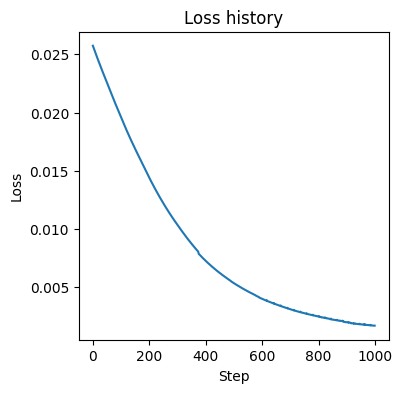

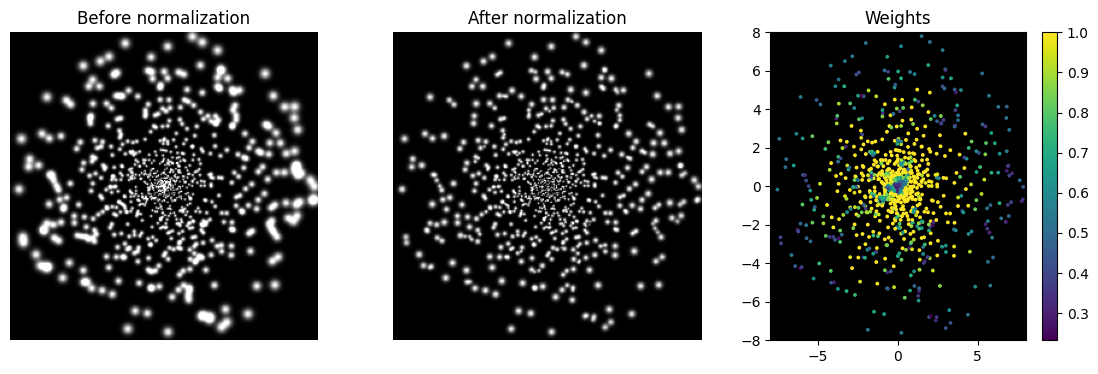

Percentage of amplitude: 73.40%


/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/pieapp.py:171: UserWarning: The original PieAPP supports only RGB images.The input images were converted to RGB by copying the grey channel 3 times.
  warnings.warn('The original PieAPP supports only RGB images.'
/home/mappel/miniconda3/envs/ML/lib/python3.8/site-packages/piq/vs

Batch 0: 1 images processed.
Batch 1: 2 images processed.
Batch 2: 3 images processed.
Batch 3: 4 images processed.
Batch 4: 5 images processed.
Batch 5: 6 images processed.
Batch 6: 7 images processed.
Batch 7: 8 images processed.
Batch 8: 9 images processed.
Batch 9: 10 images processed.
Batch 10: 11 images processed.
Batch 11: 12 images processed.
Batch 12: 13 images processed.
Batch 13: 14 images processed.
Batch 14: 15 images processed.
  Dataset Implant     Method      FSIM    PIEAPP   CONTENT     SRSIM  \
0    LaPa    1024  Grayscale  0.501372  7.749059  7.625657  0.430229   
1    LaPa    1024      Canny  0.373694  2.425947  3.726396  0.313578   
2    LaPa    1024        DoG  0.446951  6.395268  6.163525  0.388893   
3    LaPa    1024     Random  0.522464  8.122417  7.326656  0.444607   

        VSI      MDSI  
0  0.262841  0.592739  
1  0.187216  0.374620  
2  0.237757  0.517153  
3  0.281434  0.608330  


In [ ]:

# 1) Datasets. Choose one or many. Cap images with max_images below.
# COCO example:
# datasets = [dict(name='COCO',
#                  kind='coco',
#                  img_dir="/projects/prjs0344/Dynaphos/data/coco/val2017",
#                  ann_file="/projects/prjs0344/Dynaphos/data/coco/annotations/instances_val2017.json",
#                  target_hw=(256,256))]

# ImageFolder example:
datasets = [dict(name='LaPa',
                    kind='folder',
                    root="/projects/prjs0344/Dynaphos/data/example_faces_LaPa/",
                    target_hw=(256,256))]

# 2) Implant schemes
implants = [
    dict(name='1024',     path='../electrode_schemes/defaultcoordinatemap_1024.pickle', view_angle=16),
    # dict(name='4 Utah',   path='../electrode_schemes/4utaharrays.pickle',              view_angle=16),
    # dict(name='1 Utah',   path='../electrode_schemes/1utaharray.pickle',               view_angle=0.4),
    # dict(name='Utah RFs', path='../electrode_schemes/utahRFs.pickle',                  view_angle=6),
    # dict(name='Neuralink',path='../electrode_schemes/neuralink.pickle',                view_angle=25),
]

# 3) Params file
params_path = '../config/params.yaml'

# 4) Run
df = collect_results(
    datasets=datasets,
    implants=implants,
    params_path=params_path,
    max_images=50,
    save_csv="low_level_results.csv"
)

print(df.head())

# 5) LaTeX for a chosen dataset name, for example COCO
# print(df_to_latex_lowlevel(df, dataset_name='COCO'))

# # Optional quick plot, original vs phosphene for each method, averaged distances
# metrics = ['FSIM', 'PIEAPP', 'CONTENT', 'SRSIM', 'VSI', 'MDSI']
# for metric in metrics:
#     sub = df.groupby(['Dataset','Implant','Method'])[metric].mean().reset_index()

In [ ]:
df

,Dataset,Implant,Method,FSIM,PIEAPP,CONTENT,SRSIM,VSI,MDSI
0,LaPa,1024,Grayscale,0.501372,7.749059,7.625657,0.430229,0.262841,0.592739
1,LaPa,1024,Canny,0.373694,2.425947,3.726396,0.313578,0.187216,0.374620
2,LaPa,1024,DoG,0.446951,6.395268,6.163525,0.388893,0.237757,0.517153
3,LaPa,1024,Random,0.522464,8.122417,7.326656,0.444607,0.281434,0.608330
